Machine Learning models for obesity risk prediction

In [1]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns

In [2]:
# Load data
data = pd.read_csv("Data_collection_and_cleaning/processed_data/csv_files/Processed_data.csv",
                   header= 0)

Descriptive analysis

In [3]:
data.head(2)

,subjid,sex,age_days,age_years,date_of_measurement,height_cm,weight_kg,bmi,zbmi,zbmi_type
0,++7gAwn0opdNQTTFGiAPCgz5uNuQtj3PT0yB,Female,763,2.089023,2015-11-13,87.0,13.2,17.439556,1.24,Overweight
1,++7gAwn0opdNQTTFGiAPCgz5uNuQtj3PT0yB,Female,1118,3.060980,2016-11-02,96.0,15.9,17.252604,1.30,Overweight


In [58]:
print(f"Number of rows: {data.shape[0]}, Number of columns: {data.shape[1]}")

Number of rows: 95977, Number of columns: 10


In [59]:
data.describe()

,age_days,age_years,height_cm,weight_kg,bmi,zbmi
count,95977.000000,95977.000000,95977.000000,95977.00000,95977.000000,95977.000000
mean,1951.170989,5.342125,111.183477,21.88861,16.836618,0.540136
std,951.657055,2.605549,17.969964,10.20711,2.734057,1.281769
min,731.000000,2.001410,56.000000,4.75000,9.696841,-5.230000
25%,1125.000000,3.080145,96.500000,14.80000,15.095763,-0.330000
50%,1696.000000,4.643490,108.500000,18.70000,16.174885,0.430000
75%,2540.000000,6.954284,124.000000,26.00000,17.728532,1.310000
max,5200.000000,14.237116,180.000000,106.50000,38.295657,9.300000


In [54]:
data.dtypes

subjid                  object
sex                     object
age_days                 int64
age_years              float64
date_of_measurement     object
height_cm              float64
weight_kg              float64
bmi                    float64
zbmi                   float64
zbmi_type               object
dtype: object

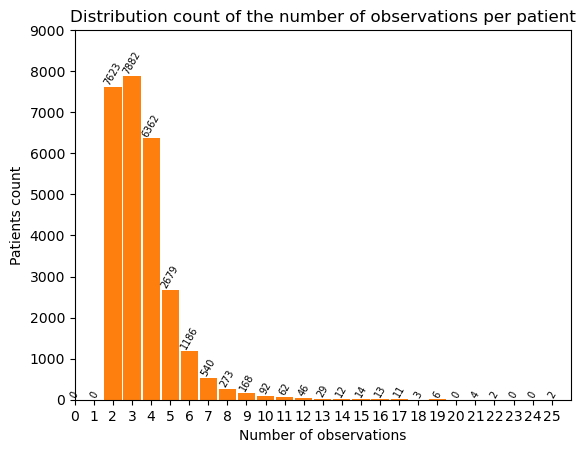

In [52]:
# Plot number of patients by number of obs
n_patients = data.value_counts("subjid")
counts = np.bincount(n_patients)
n_bins = n_patients.max()
labels = range(n_bins+1)

fig, ax = plt.subplots()
ax.bar(labels, counts, width= 0.9, align= 'center')

ax.set(xticks= labels, xlim= [0, n_bins+1], ylim= [0, 9000])
ax.bar_label(ax.bar(labels, counts, width= 0.9, align= 'center'),
             counts, rotation= 60, fontsize= 7)
ax.set_title("Distribution count of the number of observations per patient")
ax.set_ylabel("Patients count")
ax.set_xlabel("Number of observations")

plt.show()

In [66]:
# Check NA count
data.isna().sum()

subjid                 0
sex                    0
age_days               0
age_years              0
date_of_measurement    0
height_cm              0
weight_kg              0
bmi                    0
zbmi                   0
zbmi_type              0
dtype: int64

In [ ]:
data.groupby("subjid").value_counts()

4.6434902838525085